In [1]:
import cv2
import os
import pickle
import numpy as np
import pandas as pd
import src.modules.data_manipulation as dm
import src.modules.dataset_ops as dops
import src.modules.utils as utils
import src.modules.stat_utils as st
from src.modules.image_vectorizer import ImageVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import PrecisionRecallDisplay, auc

2024-08-06 01:28:03.100458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 01:28:03.129479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 01:28:03.130501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 01:28:03.768178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Vectorizing Datasets

In [2]:
vectorizer = ImageVectorizer()
vectorizer.initialize()

## Vectorizing Padded_152

In [ ]:
dataset_path = './data/preprocessed/resized_152_padded'
destination_root = './data/vectorized/padded_152'
path_suffix = 'pad_152'

dops.vectorize_processed_dataset(dataset_path, destination_root, path_suffix, vectorizer = vectorizer)

## Vectorizing Stretched_152

In [ ]:
dataset_path = './data/preprocessed/resized_152_stretched'
destination_root = './data/vectorized/stretched_152'
path_suffix = 'stretched_152'

dops.vectorize_processed_dataset(dataset_path, destination_root, path_suffix, vectorizer = vectorizer)

## Vectorizing Ghosh_152

In [ ]:
dataset_path = './data/preprocessed/resized_152_ghosh'
destination_root = './data/vectorized/ghosh_152'
path_suffix = 'ghosh_152'

dops.vectorize_processed_dataset(dataset_path, destination_root, path_suffix, vectorizer = vectorizer)

## Vectorizing Manually Inpsected Random Subsample Using Ghosh

In [ ]:
dataset_path = './data/preprocessed/random_sample_resized'
destination_root = './data/vectorized/random_sample'
path_suffix = 'random_sample'

dops.vectorize_processed_dataset(dataset_path, destination_root, path_suffix, vectorizer = vectorizer)

## Vectorizing Personal Images

In [ ]:
dataset_path = './data/personal_images/preprocessed'
destination_root = './data/personal_images/vectorized'
path_suffix = 'personal'

dops.vectorize_processed_dataset(dataset_path, destination_root, path_suffix, vectorizer = vectorizer)

## Vectorizing Personal Images Batch 2

In [3]:
dataset_path = './data/personal_images_batch2/preprocessed'
destination_root = './data/personal_images_batch2/vectorized'
path_suffix = 'personal'

dops.vectorize_processed_dataset(dataset_path, destination_root, path_suffix, vectorizer = vectorizer)

Vectorizing image 1 from ./data/personal_images_batch2/preprocessed/Adam-01.png
1/1 [==============================] - 0s 67ms/step
Pickling vector 1 at ./data/personal_images_batch2/vectorized/Adam-01-personal.pickle
Vectorizing image 2 from ./data/personal_images_batch2/preprocessed/Adam-02.png
1/1 [==============================] - 0s 58ms/step
Pickling vector 2 at ./data/personal_images_batch2/vectorized/Adam-02-personal.pickle
Vectorizing image 3 from ./data/personal_images_batch2/preprocessed/Dan1-01.png
1/1 [==============================] - 0s 73ms/step
Pickling vector 3 at ./data/personal_images_batch2/vectorized/Dan1-01-personal.pickle
Vectorizing image 4 from ./data/personal_images_batch2/preprocessed/Dan1-02.png
1/1 [==============================] - 0s 81ms/step
Pickling vector 4 at ./data/personal_images_batch2/vectorized/Dan1-02-personal.pickle
Vectorizing image 5 from ./data/personal_images_batch2/preprocessed/Dan1-03.png
1/1 [==============================] - 0s 88ms/s

1/1 [==============================] - 0s 92ms/step
Pickling vector 38 at ./data/personal_images_batch2/vectorized/Lauren-01-personal.pickle
Vectorizing image 39 from ./data/personal_images_batch2/preprocessed/Lauren-02.png
1/1 [==============================] - 0s 78ms/step
Pickling vector 39 at ./data/personal_images_batch2/vectorized/Lauren-02-personal.pickle
Vectorizing image 40 from ./data/personal_images_batch2/preprocessed/Lauren-03.png
1/1 [==============================] - 0s 73ms/step
Pickling vector 40 at ./data/personal_images_batch2/vectorized/Lauren-03-personal.pickle
Vectorizing image 41 from ./data/personal_images_batch2/preprocessed/Lauren-04.png
1/1 [==============================] - 0s 67ms/step
Pickling vector 41 at ./data/personal_images_batch2/vectorized/Lauren-04-personal.pickle
Vectorizing image 42 from ./data/personal_images_batch2/preprocessed/Lauren-05.png
1/1 [==============================] - 0s 88ms/step
Pickling vector 42 at ./data/personal_images_batch2/

1/1 [==============================] - 0s 171ms/step
Pickling vector 75 at ./data/personal_images_batch2/vectorized/Model2-09-personal.pickle
Vectorizing image 76 from ./data/personal_images_batch2/preprocessed/Model2-10.png
1/1 [==============================] - 0s 73ms/step
Pickling vector 76 at ./data/personal_images_batch2/vectorized/Model2-10-personal.pickle
Vectorizing image 77 from ./data/personal_images_batch2/preprocessed/Model2-11.png
1/1 [==============================] - 0s 55ms/step
Pickling vector 77 at ./data/personal_images_batch2/vectorized/Model2-11-personal.pickle
Vectorizing image 78 from ./data/personal_images_batch2/preprocessed/Model2-12.png
1/1 [==============================] - 0s 57ms/step
Pickling vector 78 at ./data/personal_images_batch2/vectorized/Model2-12-personal.pickle
Vectorizing image 79 from ./data/personal_images_batch2/preprocessed/Model2-13.png
1/1 [==============================] - 0s 60ms/step
Pickling vector 79 at ./data/personal_images_batch2

# Processing Intra- and Inter-Label Distances

## Intra- and Inter-Distances for Padded_152

### Intra-Distances for Padded_152

In [ ]:
root_path = './data/vectorized/padded_152'
json_path = './data/vectorized/padded_152_intra_distances.json'

In [ ]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [ ]:
# Calculate intra-label distances and write to disk
dm.calculate_intra_distances(unique_names, all_paths, vectors, json_path)

In [ ]:
# Read intra-label distances from disk and place into dataframe
intra_df = utils.load_json_into_frame(json_path)

In [ ]:
# Verifying correct counts for each label
all_paths = utils.get_all_paths(root_path)
intra_df_counts = dm.confirm_intra_distance_counts(intra_df, all_paths)
intra_df_counts.loc[intra_df_counts.proper_count == False]

In [ ]:
# Writing intra-label l2 distances to separate csv for further use
l2_csv_path = './data/vectorized/padded_152_intra_distances_l2.csv'
intra_l2_df = dm.get_distance_df(intra_df, 'l2_distances')
intra_l2_df.to_csv(l2_csv_path, index = False)

In [ ]:
# Writing intra-label cosine distances to separate csv for further use
cos_csv_path = './data/vectorized/padded_152_intra_distances_cos.csv'
intra_cos_df = dm.get_distance_df(intra_df, 'cosine_distances')
intra_cos_df.to_csv(cos_csv_path, index = False)

### Inter-Label Distances for Padded_152

In [ ]:
root_path = './data/vectorized/padded_152'
distances_stem = './data/vectorized/padded_152_inter_distances'
vector_leaf = '-pad'

In [ ]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [ ]:
# Calculating inter-label distances and writing to disk
# Processing was able to be done using 20 GB of memory, required ~2-3 hours to process
dm.calculate_inter_distances(unique_names, all_paths, vectors, distances_stem)

In [ ]:
# Grab all paths of inter-label json batches
inter_df_jsons = dm.get_batch_paths(distances_stem, '.json')

In [ ]:
# Process into batch csvs
# This processing was able to be done with 20 GB of memory
dm.write_inter_batch_frames(inter_df_jsons, distances_stem)

In [ ]:
# Verifying correct counts for each label
pair_df_counts = dm.confirm_inter_distance_counts(distances_stem, vector_leaf)
pair_df_counts.loc[pair_df_counts.proper_count == False]

## Intra- and Inter-Distances for Stretched_152

### Intra-Distances for Stretched_152

In [ ]:
root_path = './data/vectorized/stretched_152'
json_path = './data/vectorized/stretched_152_intra_distances.json'

In [ ]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [ ]:
# Calculate intra-label distances and write to disk
dm.calculate_intra_distances(unique_names, all_paths, vectors, json_path)

In [ ]:
# Read intra-label distances from disk and place into dataframe
intra_df = utils.load_json_into_frame(json_path)

In [ ]:
# Verifying correct counts for each label
all_paths = utils.get_all_paths(root_path)
intra_df_counts = dm.confirm_intra_distance_counts(intra_df, all_paths)
intra_df_counts.loc[intra_df_counts.proper_count == False]

In [ ]:
# Writing intra-label l2 distances to separate csv for further use
l2_csv_path = './data/vectorized/stretched_152_intra_distances_l2.csv'
intra_l2_df = dm.get_distance_df(intra_df, 'l2_distances')
intra_l2_df.to_csv(l2_csv_path, index = False)

In [ ]:
# Writing intra-label cosine distances to separate csv for further use
cos_csv_path = './data/vectorized/stretched_152_intra_distances_cos.csv'
intra_cos_df = dm.get_distance_df(intra_df, 'cosine_distances')
intra_cos_df.to_csv(cos_csv_path, index = False)

### Inter-Distances for Stretched_152

In [ ]:
root_path = './data/vectorized/stretched_152'
distances_stem = './data/vectorized/stretched_152_inter_distances'
vector_leaf = '-stretched'

In [ ]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [ ]:
# Calculating inter-label distances and writing to disk
# Processing was able to be done using 20 GB of memory, required ~2-3 hours to process
dm.calculate_inter_distances(unique_names, all_paths, vectors, distances_stem)

In [ ]:
# Grab all paths of inter-label json batches
inter_df_jsons = dm.get_batch_paths(distances_stem, '.json')

In [ ]:
# Process into batch csvs
# This processing was able to be done with 20 GB of memory
dm.write_inter_batch_frames(inter_df_jsons, distances_stem)

In [ ]:
# Verifying correct counts for each label
pair_df_counts = dm.confirm_inter_distance_counts(distances_stem, vector_leaf)
pair_df_counts.loc[pair_df_counts.proper_count == False]

## Intra- and Inter-Distances for Ghosh_152

### Intra-Distances for Ghosh_152

In [ ]:
root_path = './data/vectorized/ghosh_152'
json_path = './data/vectorized/ghosh_152_intra_distances.json'

In [ ]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [ ]:
# Calculate intra-label distances and write to disk
dm.calculate_intra_distances(unique_names, all_paths, vectors, json_path)

In [ ]:
# Read intra-label distances from disk and place into dataframe
intra_df = utils.load_json_into_frame(json_path)

In [ ]:
# Verifying correct counts for each label
all_paths = utils.get_all_paths(root_path)
intra_df_counts = dm.confirm_intra_distance_counts(intra_df, all_paths)
intra_df_counts.loc[intra_df_counts.proper_count == False]

In [ ]:
# Writing intra-label l2 distances to separate csv for further use
l2_csv_path = './data/vectorized/ghosh_152_intra_distances_l2.csv'
intra_l2_df = dm.get_distance_df(intra_df, 'l2_distances')
intra_l2_df.to_csv(l2_csv_path, index = False)

In [ ]:
# Writing intra-label cosine distances to separate csv for further use
cos_csv_path = './data/vectorized/ghosh_152_intra_distances_cos.csv'
intra_cos_df = dm.get_distance_df(intra_df, 'cosine_distances')
intra_cos_df.to_csv(cos_csv_path, index = False)

### Inter-Distances for Ghosh_152

In [ ]:
root_path = './data/vectorized/ghosh_152'
distances_stem = './data/vectorized/ghosh_152_inter_distances'
vector_leaf = '-ghosh'

In [ ]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [ ]:
# Calculating inter-label distances and writing to disk
# Processing was able to be done using 20 GB of memory, required ~2-3 hours to process
dm.calculate_inter_distances(unique_names, all_paths, vectors, distances_stem)

In [ ]:
# Grab all paths of inter-label json batches
inter_df_jsons = dm.get_batch_paths(distances_stem, '.json')

In [ ]:
# Process into batch csvs
# This processing was able to be done with 20 GB of memory
dm.write_inter_batch_frames(inter_df_jsons, distances_stem)

In [ ]:
# Verifying correct counts for each label
pair_df_counts = dm.confirm_inter_distance_counts(distances_stem, vector_leaf)
pair_df_counts.loc[pair_df_counts.proper_count == False]

## Intra- and Inter-Distances for Random Sample

### Intra-Distances for Random Sample

In [4]:
root_path = './data/vectorized/random_sample'
json_path = './data/vectorized/random_sample_intra_distances.json'

In [5]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [6]:
# Calculate intra-label distances and write to disk
dm.calculate_intra_distances(unique_names, all_paths, vectors, json_path)

Calculating intra-label distances for Akbar_Hashemi_Rafsanjani
Appending inter-label distances for Akbar_Hashemi_Rafsanjani to dictionary
Calculating intra-label distances for Alexander_Downer
Appending inter-label distances for Alexander_Downer to dictionary
Calculating intra-label distances for Alexander_Losyukov
Appending inter-label distances for Alexander_Losyukov to dictionary
Calculating intra-label distances for Alexandra_Stevenson
Appending inter-label distances for Alexandra_Stevenson to dictionary
Calculating intra-label distances for Amer_al-Saadi
Appending inter-label distances for Amer_al-Saadi to dictionary
Calculating intra-label distances for Anders_Fogh_Rasmussen
Appending inter-label distances for Anders_Fogh_Rasmussen to dictionary
Calculating intra-label distances for Angelo_Reyes
Appending inter-label distances for Angelo_Reyes to dictionary
Calculating intra-label distances for Anne_Krueger
Appending inter-label distances for Anne_Krueger to dictionary
Calculatin

Appending inter-label distances for Prince_Harry to dictionary
Calculating intra-label distances for Prince_Naruhito
Appending inter-label distances for Prince_Naruhito to dictionary
Calculating intra-label distances for Pupi_Avati
Appending inter-label distances for Pupi_Avati to dictionary
Calculating intra-label distances for Rachel_Griffiths
Appending inter-label distances for Rachel_Griffiths to dictionary
Calculating intra-label distances for Raoul_Ruiz
Appending inter-label distances for Raoul_Ruiz to dictionary
Calculating intra-label distances for Rick_Carlisle
Appending inter-label distances for Rick_Carlisle to dictionary
Calculating intra-label distances for Rick_Dinse
Appending inter-label distances for Rick_Dinse to dictionary
Calculating intra-label distances for Rick_Stansbury
Appending inter-label distances for Rick_Stansbury to dictionary
Calculating intra-label distances for Rita_Wilson
Appending inter-label distances for Rita_Wilson to dictionary
Calculating intra-l

In [7]:
# Read intra-label distances from disk and place into dataframe
intra_df = utils.load_json_into_frame(json_path)

In [8]:
# Verifying correct counts for each label
all_paths = utils.get_all_paths(root_path)
intra_df_counts = dm.confirm_intra_distance_counts(intra_df, all_paths)
intra_df_counts.loc[intra_df_counts.proper_count == False]

,name,counts,correct_counts,proper_count


In [9]:
# Writing intra-label l2 distances to separate csv for further use
l2_csv_path = './data/vectorized/random_sample_intra_distances_l2.csv'
intra_l2_df = dm.get_distance_df(intra_df, 'l2_distances')
intra_l2_df.to_csv(l2_csv_path, index = False)

In [10]:
# Writing intra-label cosine distances to separate csv for further use
cos_csv_path = './data/vectorized/random_sample_intra_distances_cos.csv'
intra_cos_df = dm.get_distance_df(intra_df, 'cosine_distances')
intra_cos_df.to_csv(cos_csv_path, index = False)

### Inter-Distances for Random Sample

In [112]:
root_path = './data/vectorized/random_sample'
distances_stem = './data/vectorized/random_sample_inter_distances'
vector_leaf = '-random_sample'

In [113]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [114]:
# Calculating inter-label distances and writing to disk
# Processing was able to be done using 20 GB of memory, required ~2-3 hours to process
dm.calculate_inter_distances(unique_names, all_paths, vectors, distances_stem)

Calculating inter-label distances for Akbar_Hashemi_Rafsanjani
Appending inter-label distances for Akbar_Hashemi_Rafsanjani to dictionary
Calculating inter-label distances for Alexander_Downer
Appending inter-label distances for Alexander_Downer to dictionary
Calculating inter-label distances for Alexander_Losyukov
Appending inter-label distances for Alexander_Losyukov to dictionary
Calculating inter-label distances for Alexandra_Stevenson
Appending inter-label distances for Alexandra_Stevenson to dictionary
Calculating inter-label distances for Amer_al-Saadi
Appending inter-label distances for Amer_al-Saadi to dictionary
Calculating inter-label distances for Anders_Fogh_Rasmussen
Appending inter-label distances for Anders_Fogh_Rasmussen to dictionary
Calculating inter-label distances for Angelo_Reyes
Appending inter-label distances for Angelo_Reyes to dictionary
Calculating inter-label distances for Anne_Krueger
Appending inter-label distances for Anne_Krueger to dictionary
Calculatin

Appending inter-label distances for Jennifer_Keller to dictionary
Calculating inter-label distances for Jerry_Regier
Appending inter-label distances for Jerry_Regier to dictionary
Calculating inter-label distances for Jerry_Springer
Appending inter-label distances for Jerry_Springer to dictionary
Calculating inter-label distances for Jesse_Harris
Appending inter-label distances for Jesse_Harris to dictionary
Calculating inter-label distances for Jesse_Ventura
Appending inter-label distances for Jesse_Ventura to dictionary
Calculating inter-label distances for Jodie_Foster
Appending inter-label distances for Jodie_Foster to dictionary
Calculating inter-label distances for Joe_Torre
Appending inter-label distances for Joe_Torre to dictionary
Calculating inter-label distances for John_Mayer
Appending inter-label distances for John_Mayer to dictionary
Calculating inter-label distances for John_Rosa
Appending inter-label distances for John_Rosa to dictionary
Calculating inter-label distance

In [115]:
# Grab all paths of inter-label json batches
inter_df_jsons = dm.get_batch_paths(distances_stem, '.json')

In [116]:
# Process into batch csvs
dm.write_inter_batch_frames(inter_df_jsons, distances_stem)

In [147]:
# Verifying correct counts for each label
pair_df_counts = dm.confirm_inter_distance_counts(distances_stem, vector_leaf)
pair_df_counts.loc[pair_df_counts.proper_count == False]

,image,counts,correct_counts,proper_count


### Intra-Distances for Personal Images

In [3]:
root_path = './data/personal_images/vectorized'
json_path = './data/personal_images/personal_intra_distances.json'

In [4]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [5]:
# Calculate intra-label distances and write to disk
dm.calculate_intra_distances(unique_names, all_paths, vectors, json_path)

Calculating intra-label distances for Jack
Appending inter-label distances for Jack to dictionary
Calculating intra-label distances for Janice
Appending inter-label distances for Janice to dictionary
Calculating intra-label distances for Sasha
Appending inter-label distances for Sasha to dictionary


In [6]:
# Read intra-label distances from disk and place into dataframe
intra_df = utils.load_json_into_frame(json_path)

In [7]:
# Verifying correct counts for each label
all_paths = utils.get_all_paths(root_path)
intra_df_counts = dm.confirm_intra_distance_counts(intra_df, all_paths)
intra_df_counts.loc[intra_df_counts.proper_count == False]

,name,counts,correct_counts,proper_count


In [8]:
# Writing intra-label l2 distances to separate csv for further use
l2_csv_path = './data/personal_images/personal_intra_distances_l2.csv'
intra_l2_df = dm.get_distance_df(intra_df, 'l2_distances')
intra_l2_df.to_csv(l2_csv_path, index = False)

In [9]:
# Writing intra-label cosine distances to separate csv for further use
cos_csv_path = './data/personal_images/personal_intra_distances_cos.csv'
intra_cos_df = dm.get_distance_df(intra_df, 'cosine_distances')
intra_cos_df.to_csv(cos_csv_path, index = False)

### Inter-Distances for Personal Images

In [10]:
root_path = './data/personal_images/vectorized'
distances_stem = './data/personal_images/personal_inter_distances'
vector_leaf = '-personal.pickle'

In [5]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path)
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [6]:
# Calculating inter-label distances and writing to disk
# Processing was able to be done using 20 GB of memory, required ~2-3 hours to process
dm.calculate_inter_distances(unique_names, all_paths, vectors, distances_stem)

Calculating inter-label distances for Jack
Appending inter-label distances for Jack to dictionary
Calculating inter-label distances for Janice
Appending inter-label distances for Janice to dictionary
Calculating inter-label distances for Sasha
Appending inter-label distances for Sasha to dictionary
Writing inter-distances intermediate results to ./data/personal_images/personal_inter_distances0002.json


In [7]:
# Grab all paths of inter-label json batches
inter_df_jsons = dm.get_batch_paths(distances_stem, '.json', root = './data/personal_images')

In [8]:
# Process into batch csvs
dm.write_inter_batch_frames(inter_df_jsons, distances_stem, slices = (0, 3))

In [11]:
# Verifying correct counts for each label
pair_df_counts = dm.confirm_inter_distance_counts(distances_stem, vector_leaf, root = './data/personal_images')
pair_df_counts.loc[pair_df_counts.proper_count == False]

,image,counts,correct_counts,proper_count


## Intra- and Inter-Distances for Personal Images Batch 2

### Intra-Distances for Personal Images Batch 2

In [18]:
root_path = './data/personal_images_batch2/vectorized'
json_path = './data/personal_images_batch2/personal_intra_distances.json'

In [19]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path, string_delim = '-')
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [20]:
# Calculate intra-label distances and write to disk
dm.calculate_intra_distances(unique_names, all_paths, vectors, json_path, string_delim = '-')

Calculating intra-label distances for Adam
Appending inter-label distances for Adam to dictionary
Calculating intra-label distances for Dan1
Appending inter-label distances for Dan1 to dictionary
Calculating intra-label distances for Dan2
Appending inter-label distances for Dan2 to dictionary
Calculating intra-label distances for Ed
Appending inter-label distances for Ed to dictionary
Calculating intra-label distances for Eric
Appending inter-label distances for Eric to dictionary
Calculating intra-label distances for Girl
Appending inter-label distances for Girl to dictionary
Calculating intra-label distances for Izhak
Appending inter-label distances for Izhak to dictionary
Calculating intra-label distances for Jack
Appending inter-label distances for Jack to dictionary
Calculating intra-label distances for Jen
Appending inter-label distances for Jen to dictionary
Calculating intra-label distances for Josh1
Appending inter-label distances for Josh1 to dictionary
Calculating intra-labe

In [21]:
# Read intra-label distances from disk and place into dataframe
intra_df = utils.load_json_into_frame(json_path)

In [24]:
# Verifying correct counts for each label
all_paths = utils.get_all_paths(root_path)
intra_df_counts = dm.confirm_intra_distance_counts(intra_df, all_paths, string_delim = '-')
intra_df_counts.loc[intra_df_counts.proper_count == False]

,name,counts,correct_counts,proper_count


In [25]:
# Writing intra-label l2 distances to separate csv for further use
l2_csv_path = './data/personal_images_batch2/personal_intra_distances_l2.csv'
intra_l2_df = dm.get_distance_df(intra_df, 'l2_distances')
intra_l2_df.to_csv(l2_csv_path, index = False)

In [26]:
# Writing intra-label cosine distances to separate csv for further use
cos_csv_path = './data/personal_images_batch2/personal_intra_distances_cos.csv'
intra_cos_df = dm.get_distance_df(intra_df, 'cosine_distances')
intra_cos_df.to_csv(cos_csv_path, index = False)

### Inter-Distances for Personal Images Batch 2

In [2]:
root_path = './data/personal_images_batch2/vectorized'
distances_stem = './data/personal_images_batch2/personal_inter_distances'
vector_leaf = '-personal.pickle'

In [3]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = utils.get_unique_names(root_path, string_delim = '-')
all_paths, vectors = dm.get_all_paths_and_vectors(root_path)

In [4]:
# Calculating inter-label distances and writing to disk
# Processing was able to be done using 20 GB of memory, required ~2-3 hours to process
dm.calculate_inter_distances(unique_names, all_paths, vectors, distances_stem, string_delim = '-')

Calculating inter-label distances for Adam
Appending inter-label distances for Adam to dictionary
Calculating inter-label distances for Dan1
Appending inter-label distances for Dan1 to dictionary
Calculating inter-label distances for Dan2
Appending inter-label distances for Dan2 to dictionary
Calculating inter-label distances for Ed
Appending inter-label distances for Ed to dictionary
Calculating inter-label distances for Eric
Appending inter-label distances for Eric to dictionary
Calculating inter-label distances for Girl
Appending inter-label distances for Girl to dictionary
Calculating inter-label distances for Izhak
Appending inter-label distances for Izhak to dictionary
Calculating inter-label distances for Jack
Appending inter-label distances for Jack to dictionary
Calculating inter-label distances for Jen
Appending inter-label distances for Jen to dictionary
Calculating inter-label distances for Josh1
Appending inter-label distances for Josh1 to dictionary
Calculating inter-labe

In [5]:
# Grab all paths of inter-label json batches
inter_df_jsons = dm.get_batch_paths(distances_stem, '.json', root = './data/personal_images_batch2')

In [6]:
# Process into batch csvs
dm.write_inter_batch_frames(inter_df_jsons, distances_stem, slices = (0, 3))

In [7]:
# Verifying correct counts for each label
pair_df_counts = dm.confirm_inter_distance_counts(distances_stem, vector_leaf,
                                                  root = './data/personal_images_batch2', numbering_length = 3)
pair_df_counts.loc[pair_df_counts.proper_count == False]

,image,counts,correct_counts,proper_count


# Comparisons for Thresholding

## Padded_152

In [ ]:
intra_stem = 'padded_152_intra_distances_'
inter_stem = 'padded_152_inter_distances_'
intra_l2_path = os.path.join('./data/vectorized', intra_stem + 'l2.csv')
intra_cos_path = os.path.join('./data/vectorized', intra_stem + 'cos.csv')

In [ ]:
intra_l2_df = pd.read_csv(intra_l2_path)
inter_l2_df = dm.get_unbatched_frame(inter_stem, 'l2')

In [ ]:
# Descriptive statistics for intra-label l2 distances
intra_l2_df.describe()

In [ ]:
# Distribution of intra-label l2 distances
sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [ ]:
# Descriptive statistics for inter-label l2 distances
inter_l2_df.describe()

In [ ]:
# Distribution of inter-label l2 distances
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [ ]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'proportion', bins = 50, ax = ax);
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'proportion', bins = 50, ax = ax);

In [ ]:
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame(inter_stem, 'cos')

In [ ]:
# Descriptive statistics for intra-label cosine distances
intra_cos_df.describe()

In [ ]:
# Distribution of intra-label cosine distances
sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

In [ ]:
# Descriptive statistics for inter-label cosine distances
inter_cos_df.describe()

In [ ]:
# Distribution of inter-label cosine distances
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

In [ ]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'density', bins = 50, ax = ax);
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'density', bins = 50, ax = ax);

## Stretched_152

In [ ]:
intra_stem = 'stretched_152_intra_distances_'
inter_stem = 'stretched_152_inter_distances_'
intra_l2_path = os.path.join('./data/vectorized', intra_stem + 'l2.csv')
intra_cos_path = os.path.join('./data/vectorized', intra_stem + 'cos.csv')

In [ ]:
intra_l2_df = pd.read_csv(intra_l2_path)
inter_l2_df = dm.get_unbatched_frame(inter_stem, 'l2')

In [ ]:
# Descriptive statistics for intra-label l2 distances
intra_l2_df.describe()

In [ ]:
# Distribution of intra-label l2 distances
sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [ ]:
# Descriptive statistics for inter-label l2 distances
inter_l2_df.describe()

In [ ]:
# Distribution of inter-label l2 distances
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [ ]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'density', bins = 50, ax = ax);
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'density', bins = 50, ax = ax);

In [ ]:
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame(inter_stem, 'cos')

In [ ]:
# Descriptive statistics for intra-label cosine distances
intra_cos_df.describe()

In [ ]:
# Distribution of intra-label cosine distances
sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

In [ ]:
# Descriptive statistics for inter-label cosine distances
inter_cos_df.describe()

In [ ]:
# Distribution of inter-label cosine distances
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

In [ ]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'density', bins = 50, ax = ax);
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'density', bins = 50, ax = ax);

## Ghosh_152

In [4]:
intra_stem = 'ghosh_152_intra_distances_'
inter_stem = 'ghosh_152_inter_distances_'
intra_l2_path = os.path.join('./data/vectorized', intra_stem + 'l2.csv')
intra_cos_path = os.path.join('./data/vectorized', intra_stem + 'cos.csv')

In [ ]:
intra_l2_df = pd.read_csv(intra_l2_path)
inter_l2_df = dm.get_unbatched_frame(inter_stem, 'l2')

In [ ]:
# Descriptive statistics for intra-label l2 distances
intra_l2_df.describe()

In [ ]:
# Distribution of intra-label l2 distances
sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [ ]:
# Descriptive statistics for inter-label l2 distances
inter_l2_df.describe()

In [ ]:
# Distribution of inter-label l2 distances
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [ ]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'density', bins = 50, ax = ax);
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'density', bins = 50, ax = ax);

In [5]:
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame(inter_stem, 'cos')

In [ ]:
# Descriptive statistics for intra-label cosine distances
intra_cos_df.describe()

In [ ]:
# Distribution of intra-label cosine distances
sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

In [ ]:
# Descriptive statistics for inter-label cosine distances
inter_cos_df.describe()

In [ ]:
# Distribution of inter-label cosine distances
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

In [ ]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'density', bins = 50, ax = ax);
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'density', bins = 50, ax = ax);

## Random Sample

In [20]:
intra_stem = 'random_sample_intra_distances_'
inter_stem = 'random_sample_inter_distances_'
intra_l2_path = os.path.join('./data/vectorized', intra_stem + 'l2.csv')
intra_cos_path = os.path.join('./data/vectorized', intra_stem + 'cos.csv')

In [32]:
intra_l2_df = pd.read_csv(intra_l2_path)
inter_l2_df = dm.get_unbatched_frame(inter_stem, 'l2')

In [33]:
# Descriptive statistics for intra-label l2 distances
intra_l2_df.describe()

,l2_distances
count,500.000000
mean,65.500514
std,11.542427
min,27.301184
25%,57.964328
50%,65.388187
75%,74.334183
max,99.358757


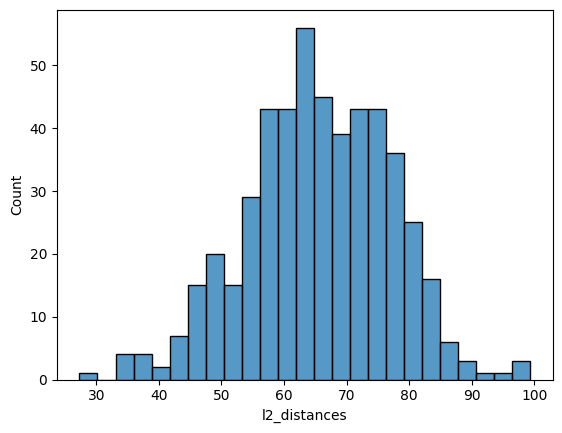

In [34]:
# Distribution of intra-label l2 distances
sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'count', bins = 25);

In [35]:
# Descriptive statistics for inter-label l2 distances
inter_l2_df.describe()

,l2_distances
count,126256.000000
mean,79.777457
std,8.393699
min,46.623009
25%,73.977518
50%,79.612900
75%,85.406538
max,118.496796


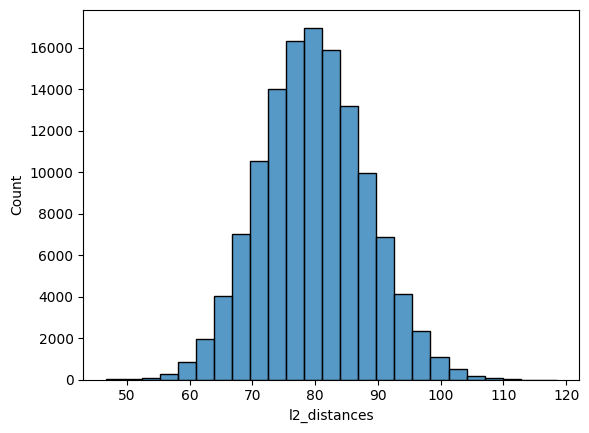

In [36]:
# Distribution of inter-label l2 distances
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'count', bins = 25);

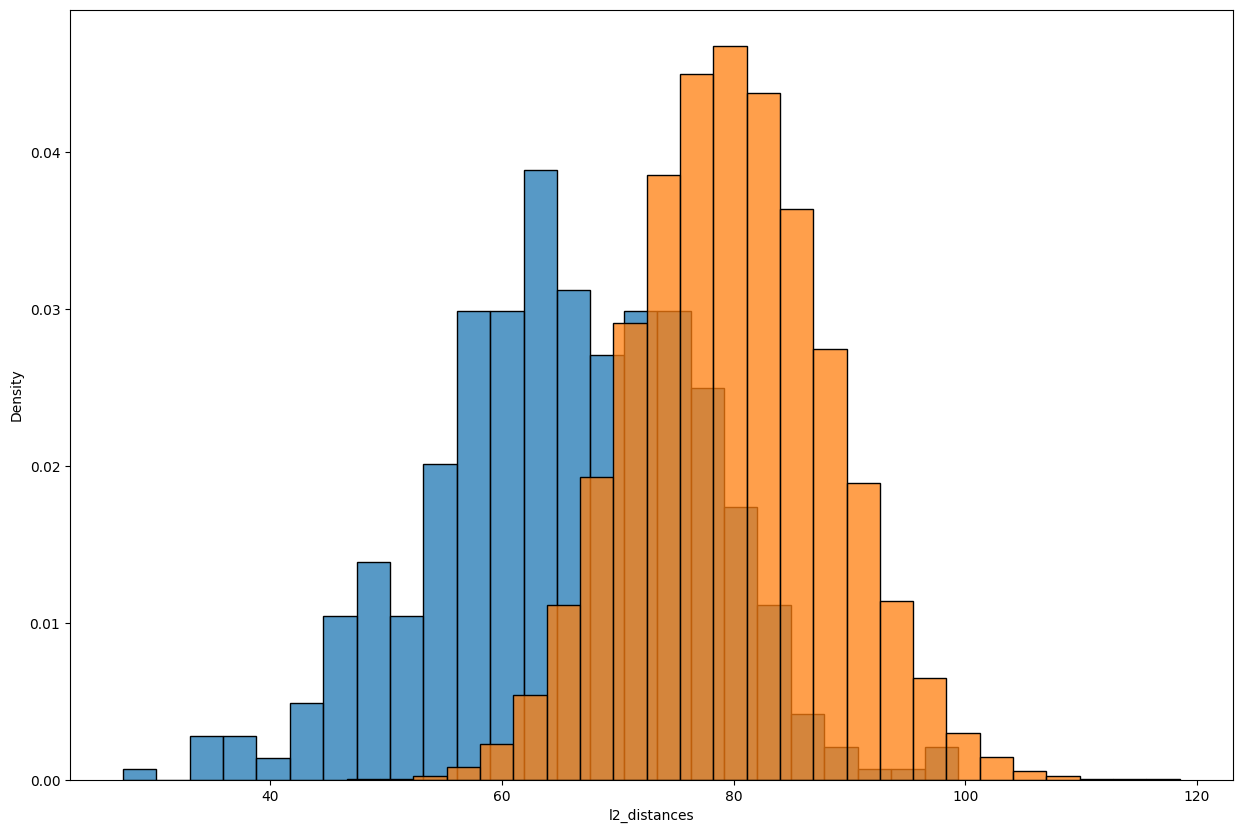

In [37]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'density', bins = 25, ax = ax);
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'density', bins = 25, ax = ax);

In [21]:
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame(inter_stem, 'cos')

In [39]:
# Descriptive statistics for intra-label cosine distances
intra_cos_df.describe()

,cosine_distances
count,500.000000
mean,0.363881
std,0.111778
min,0.079243
25%,0.290026
50%,0.364214
75%,0.440022
max,0.682245


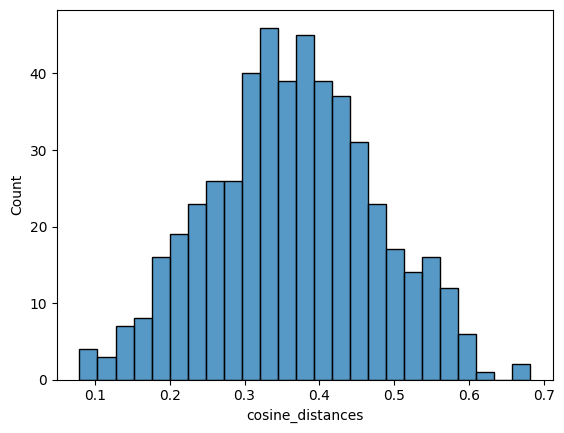

In [40]:
# Distribution of intra-label cosine distances
sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'count', bins = 25);

In [41]:
# Descriptive statistics for inter-label cosine distances
inter_cos_df.describe()

,cosine_distances
count,126256.000000
mean,0.526808
std,0.073754
min,0.242617
25%,0.476516
50%,0.528374
75%,0.578748
max,0.783843


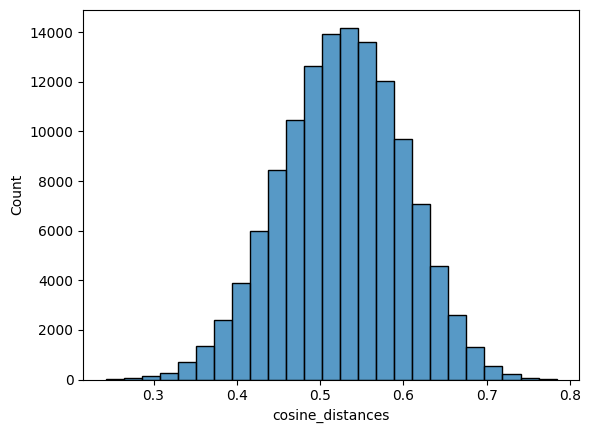

In [42]:
# Distribution of inter-label cosine distances
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'count', bins = 25);

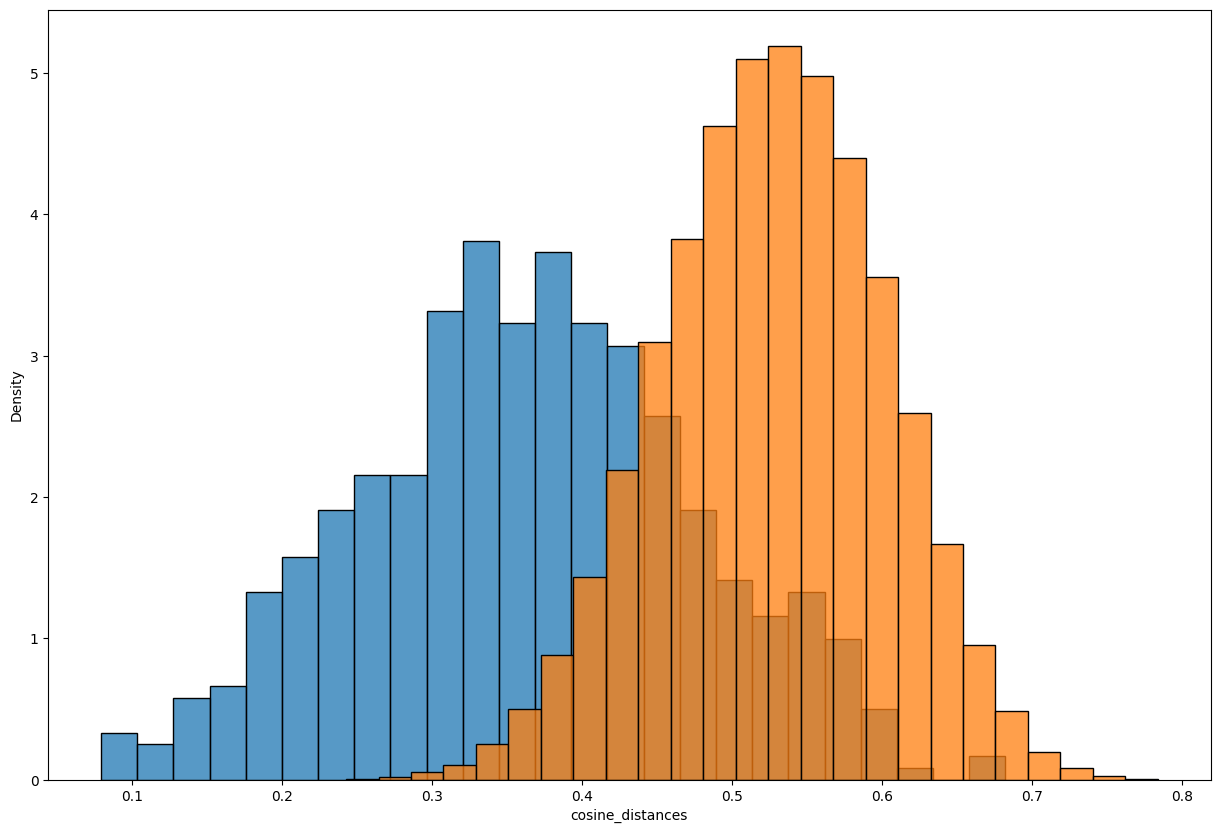

In [43]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'density', bins = 25, ax = ax);
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'density', bins = 25, ax = ax);

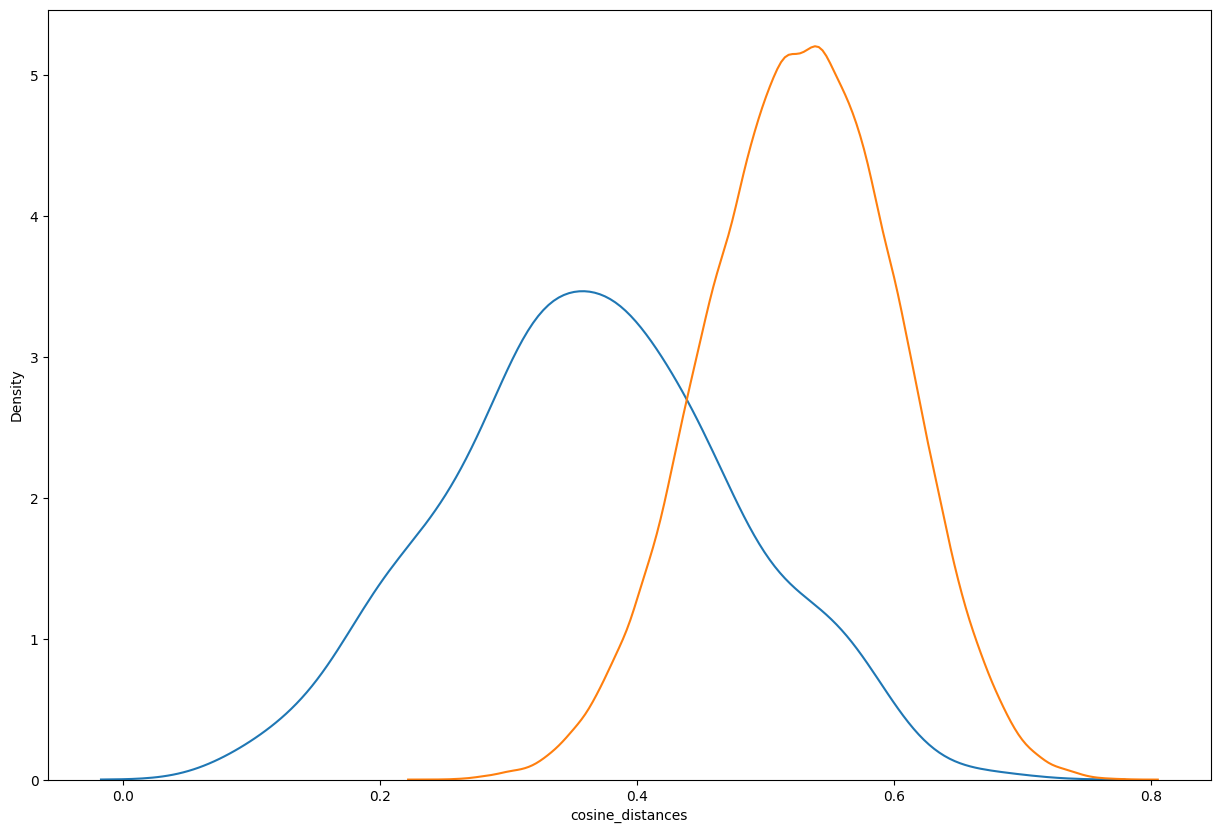

In [30]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.kdeplot(data = intra_cos_df, x = 'cosine_distances', common_norm = True, ax = ax);
sns.kdeplot(data = inter_cos_df, x = 'cosine_distances', common_norm = True, ax = ax);

## Personal Images

In [18]:
intra_stem = 'personal_intra_distances_'
inter_stem = 'personal_inter_distances_'
intra_cos_path = os.path.join('./data/personal_images', intra_stem + 'cos.csv')
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame(inter_stem, 'cos', root = './data/personal_images')

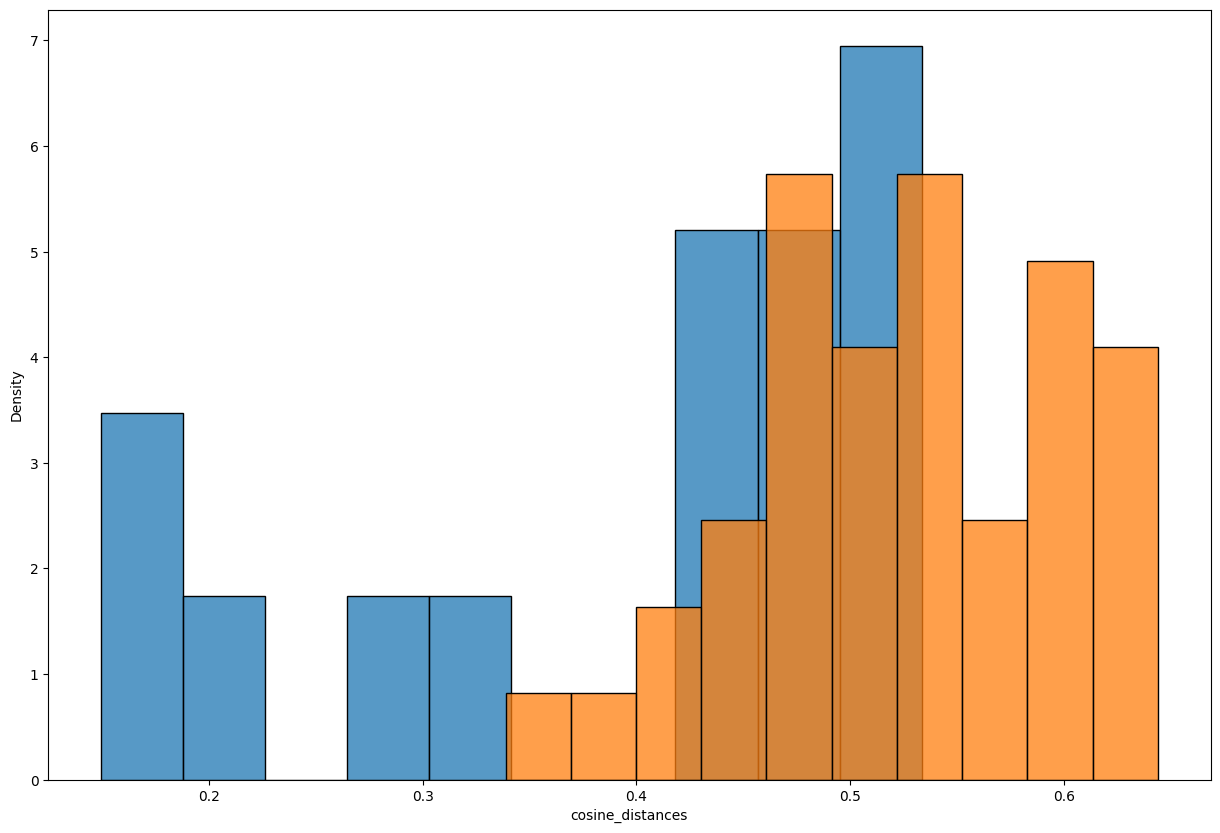

In [23]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'density', bins = 10, ax = ax);
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'density', bins = 10, ax = ax);

In [26]:
intra_cos_df['type'] = 'intra'
inter_cos_df['type'] = 'inter'
cos_df = pd.concat([intra_cos_df, inter_cos_df])

In [30]:
cos_df.loc[cos_df.type == 'intra'].describe()

,cosine_distances
count,15.000000
mean,0.397418
std,0.137187
min,0.149522
25%,0.291633
50%,0.455461
75%,0.501131
max,0.533463


In [31]:
cos_df.loc[cos_df.type == 'inter'].describe()

,cosine_distances
count,40.000000
mean,0.524977
std,0.073801
min,0.338761
25%,0.475613
50%,0.527895
75%,0.590928
max,0.643930


## Personal Images Batch 2

In [27]:
intra_stem = 'personal_intra_distances_'
inter_stem = 'personal_inter_distances_'
intra_cos_path = os.path.join('./data/personal_images_batch2', intra_stem + 'cos.csv')
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame(inter_stem, 'cos', root = './data/personal_images_batch2')

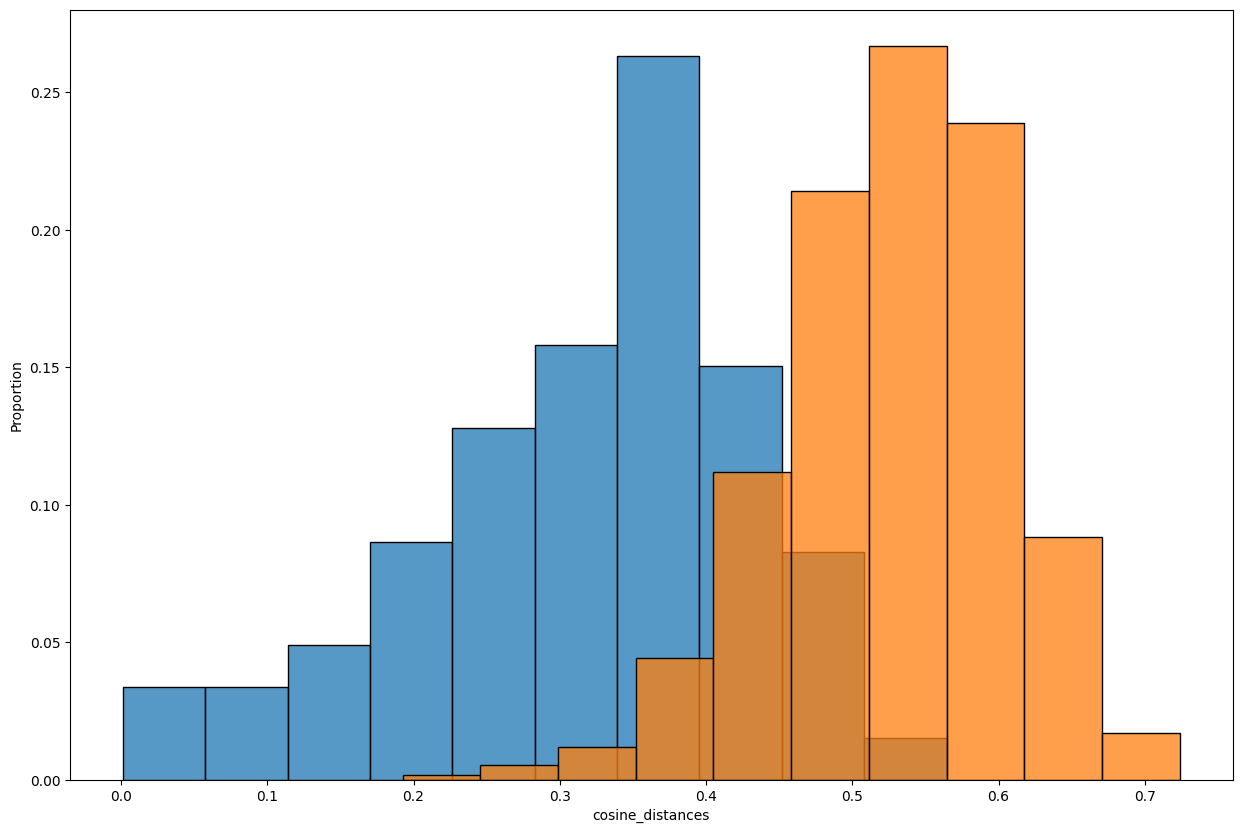

In [28]:
# Overlaid distributes of inter- and intra-label l2 distances
fig, ax = plt.subplots(figsize = (15, 10))

sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'proportion', bins = 10, ax = ax);
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'proportion', bins = 10, ax = ax);

# Investigation into Metrics

In [2]:
intra_stem = 'random_sample_intra_distances_'
inter_stem = 'random_sample_inter_distances_'
intra_cos_path = os.path.join('./data/vectorized', intra_stem + 'cos.csv')
intra_cos_df = pd.read_csv(intra_cos_path)
inter_cos_df = dm.get_unbatched_frame(inter_stem, 'cos')

In [78]:
intra_cos_df['type'] = 'intra'
inter_cos_df['type'] = 'inter'
sample_cos_df = pd.concat([intra_cos_df, inter_cos_df])

In [79]:
intra_mean = intra_cos_df['cosine_distances'].mean()
intra_std = intra_cos_df['cosine_distances'].std()

In [80]:
inter_mean = inter_cos_df['cosine_distances'].mean()
inter_std = inter_cos_df['cosine_distances'].std()

In [81]:
iterative_thresholds = np.linspace(0.1, 0.9, 100).tolist()

In [82]:
for thresh in iterative_thresholds:
    sample_cos_df[f'iterative_{thresh:.04f}'] = sample_cos_df.cosine_distances.apply(lambda x: int(x < thresh))

In [83]:
# Because each threshold columns has 1 for true and 0 for false, mean = positive count / total count
groupby = sample_cos_df.drop('cosine_distances', axis = 1).groupby(['type']).mean()

In [84]:
groupby

,iterative_0.1000,iterative_0.1081,iterative_0.1162,iterative_0.1242,iterative_0.1323,iterative_0.1404,iterative_0.1485,iterative_0.1566,iterative_0.1646,iterative_0.1727,...,iterative_0.8273,iterative_0.8354,iterative_0.8434,iterative_0.8515,iterative_0.8596,iterative_0.8677,iterative_0.8758,iterative_0.8838,iterative_0.8919,iterative_0.9000
type,,,,,,,,,,,,,,,,,,,,,
inter,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.00,0.000,0.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
intra,0.006,0.008,0.01,0.014,0.02,0.02,0.026,0.03,0.036,0.044,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [85]:
threshold_columns = groupby.columns.values

In [86]:
class0_num, class1_num = sample_cos_df['type'].value_counts().values

In [87]:
tprs, tnrs, fprs, fnrs = zip(*[st.expand_classification_rates(groupby.iloc[1][i], groupby.iloc[0][i])
                          for i in range(len(threshold_columns))])

In [88]:
tps, tns, fps, fns = zip(*[st.classification_rates_to_nominal(tprs[i], tnrs[i], fprs[i], fnrs[i], class1_num, class0_num)
                          for i in range(len(threshold_columns))])

In [89]:
prevalences = [st.prevalence(tps[i], fns[i], class1_num + class0_num) for i in range(len(threshold_columns))]
biases = [st.bias(tps[i], fps[i], class1_num + class0_num) for i in range(len(threshold_columns))]

In [90]:
balanced_accuracies = [st.balanced_accuracy_binary(tprs[i], tnrs[i]) for i in range(len(threshold_columns))]
precisions = [st.class_precision(tprs[i], fprs[i], class1_num, class0_num) for i in range(len(threshold_columns))]
informednesses = [st.informedness(tprs[i], tnrs[i]) for i in range(len(threshold_columns))]
markednesses = [st.markedness(tprs[i], fprs[i], class1_num, class0_num) for i in range(len(threshold_columns))]
mccs = [st.matthews_cc(tps[i], tns[i], fps[i], fns[i]) for i in range(len(threshold_columns))]

In [91]:
metrics_table = pd.DataFrame(columns = ['threshold_type', 'threshold_value',
                                        'balanced_accuracy', 'precision', 'recall',
                                        'f1_score', 'informedness', 'markedness', 'matthews_cc',
                                        'prevalence', 'bias'])

In [92]:
metrics_table.threshold_type = threshold_columns
metrics_table.threshold_value = iterative_thresholds
metrics_table.balanced_accuracy = balanced_accuracies
metrics_table.precision = precisions
metrics_table.recall = tprs
metrics_table.f1_score = 2 * (metrics_table.precision * metrics_table.recall) / (metrics_table.precision + metrics_table.recall)
metrics_table.informedness = informednesses
metrics_table.markedness = markednesses
metrics_table.matthews_cc = mccs
metrics_table.prevalence = prevalences
metrics_table.bias = biases

In [93]:
metrics_table

,threshold_type,threshold_value,balanced_accuracy,precision,recall,f1_score,informedness,markedness,matthews_cc,prevalence,bias
0,iterative_0.1000,0.100000,0.503,1.000000,0.006,0.011928,0.006,0.996079,0.077308,0.003945,0.000024
1,iterative_0.1081,0.108081,0.504,1.000000,0.008,0.015873,0.008,0.996087,0.089268,0.003945,0.000032
2,iterative_0.1162,0.116162,0.505,1.000000,0.010,0.019802,0.010,0.996095,0.099805,0.003945,0.000039
3,iterative_0.1242,0.124242,0.507,1.000000,0.014,0.027613,0.014,0.996110,0.118091,0.003945,0.000055
4,iterative_0.1323,0.132323,0.510,1.000000,0.020,0.039216,0.020,0.996134,0.141148,0.003945,0.000079
...,...,...,...,...,...,...,...,...,...,...,...
95,iterative_0.8677,0.867677,0.500,0.003945,1.000,0.007858,0.000,NaN,NaN,0.003945,1.000000
96,iterative_0.8758,0.875758,0.500,0.003945,1.000,0.007858,0.000,NaN,NaN,0.003945,1.000000
97,iterative_0.8838,0.883838,0.500,0.003945,1.000,0.007858,0.000,NaN,NaN,0.003945,1.000000
98,iterative_0.8919,0.891919,0.500,0.003945,1.000,0.007858,0.000,NaN,NaN,0.003945,1.000000


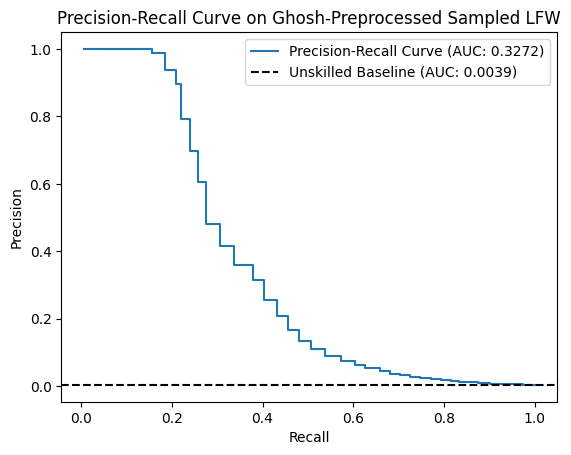

In [100]:
auc_score = auc(metrics_table.recall, metrics_table.precision)
class1_ratio = class1_num / (class1_num + class0_num)
prc = PrecisionRecallDisplay(metrics_table.precision, metrics_table.recall);
prc.plot();
hline = plt.axhline(y = class1_ratio, linestyle = '--', color = 'k');
plt.title('Precision-Recall Curve on Ghosh-Preprocessed Sampled LFW')
plt.legend([prc.line_, hline], [f'Precision-Recall Curve (AUC: {auc_score:.04f})',
                                f'Unskilled Baseline (AUC: {class1_ratio:.04f})']);

In [95]:
metrics_table.loc[metrics_table.threshold_value >= 0.25].sort_values('precision', ascending = False).head()

,threshold_type,threshold_value,balanced_accuracy,precision,recall,f1_score,informedness,markedness,matthews_cc,prevalence,bias
19,iterative_0.2535,0.253535,0.584996,0.988372,0.170,0.290102,0.169992,0.985096,0.409217,0.003945,0.000678
20,iterative_0.2616,0.261616,0.591976,0.938776,0.184,0.307692,0.183952,0.935554,0.414846,0.003945,0.000773
21,iterative_0.2697,0.269697,0.604952,0.897436,0.210,0.340357,0.209905,0.894317,0.433268,0.003945,0.000923
22,iterative_0.2778,0.277778,0.609885,0.791367,0.220,0.344288,0.219770,0.788287,0.416224,0.003945,0.001097
23,iterative_0.2859,0.285859,0.619794,0.697674,0.240,0.357143,0.239588,0.694672,0.407965,0.003945,0.001357


In [103]:
metrics_table.loc[metrics_table.threshold_value >= 0.25].sort_values('balanced_accuracy', ascending = False).head(10)

,threshold_type,threshold_value,balanced_accuracy,precision,recall,f1_score,informedness,markedness,matthews_cc,prevalence,bias
43,iterative_0.4475,0.447475,0.812796,0.020455,0.772,0.039853,0.625591,0.019398,0.110160,0.003945,0.148877
42,iterative_0.4394,0.439394,0.811724,0.023539,0.746,0.045638,0.623447,0.022394,0.118159,0.003945,0.125012
44,iterative_0.4556,0.455556,0.811063,0.017966,0.794,0.035137,0.622127,0.016982,0.102786,0.003945,0.174327
41,iterative_0.4313,0.431313,0.811052,0.027368,0.724,0.052743,0.622104,0.026153,0.127553,0.003945,0.104350
40,iterative_0.4232,0.423232,0.810026,0.032143,0.704,0.061479,0.620052,0.030865,0.138340,0.003945,0.086394
45,iterative_0.4636,0.463636,0.807577,0.015835,0.816,0.031067,0.615154,0.014924,0.095815,0.003945,0.203272
39,iterative_0.4152,0.415152,0.805550,0.037615,0.680,0.071286,0.611100,0.036256,0.148848,0.003945,0.071310
38,iterative_0.4071,0.407071,0.800954,0.044393,0.658,0.083175,0.601908,0.042961,0.160805,0.003945,0.058467
46,iterative_0.4717,0.471717,0.800394,0.014050,0.832,0.027634,0.600787,0.013186,0.089004,0.003945,0.233583
47,iterative_0.4798,0.479798,0.793323,0.012621,0.850,0.024872,0.586646,0.011815,0.083254,0.003945,0.265668


In [102]:
metrics_table.loc[metrics_table.threshold_value >= 0.25].sort_values('f1_score', ascending = False).head(10)

,threshold_type,threshold_value,balanced_accuracy,precision,recall,f1_score,informedness,markedness,matthews_cc,prevalence,bias
24,iterative_0.2939,0.293939,0.628667,0.605634,0.258,0.361851,0.257335,0.602702,0.393822,0.003945,0.001680
23,iterative_0.2859,0.285859,0.619794,0.697674,0.240,0.357143,0.239588,0.694672,0.407965,0.003945,0.001357
26,iterative_0.3101,0.310101,0.652145,0.414634,0.306,0.352129,0.304289,0.411889,0.354024,0.003945,0.002911
25,iterative_0.3020,0.302020,0.637410,0.480836,0.276,0.350699,0.274820,0.477974,0.362432,0.003945,0.002264
27,iterative_0.3182,0.318182,0.667804,0.358811,0.338,0.348095,0.335608,0.356190,0.345746,0.003945,0.003716
22,iterative_0.2778,0.277778,0.609885,0.791367,0.220,0.344288,0.219770,0.788287,0.416224,0.003945,0.001097
28,iterative_0.3263,0.326263,0.687368,0.314476,0.378,0.343324,0.374737,0.312011,0.341938,0.003945,0.004741
21,iterative_0.2697,0.269697,0.604952,0.897436,0.210,0.340357,0.209905,0.894317,0.433268,0.003945,0.000923
29,iterative_0.3343,0.334343,0.699671,0.255696,0.404,0.313178,0.399343,0.253330,0.318066,0.003945,0.006232
20,iterative_0.2616,0.261616,0.591976,0.938776,0.184,0.307692,0.183952,0.935554,0.414846,0.003945,0.000773


In [101]:
metrics_table.loc[metrics_table.threshold_value >= 0.25].sort_values('matthews_cc', ascending = False).head(10)

,threshold_type,threshold_value,balanced_accuracy,precision,recall,f1_score,informedness,markedness,matthews_cc,prevalence,bias
21,iterative_0.2697,0.269697,0.604952,0.897436,0.210,0.340357,0.209905,0.894317,0.433268,0.003945,0.000923
22,iterative_0.2778,0.277778,0.609885,0.791367,0.220,0.344288,0.219770,0.788287,0.416224,0.003945,0.001097
20,iterative_0.2616,0.261616,0.591976,0.938776,0.184,0.307692,0.183952,0.935554,0.414846,0.003945,0.000773
19,iterative_0.2535,0.253535,0.584996,0.988372,0.170,0.290102,0.169992,0.985096,0.409217,0.003945,0.000678
23,iterative_0.2859,0.285859,0.619794,0.697674,0.240,0.357143,0.239588,0.694672,0.407965,0.003945,0.001357
24,iterative_0.2939,0.293939,0.628667,0.605634,0.258,0.361851,0.257335,0.602702,0.393822,0.003945,0.001680
25,iterative_0.3020,0.302020,0.637410,0.480836,0.276,0.350699,0.274820,0.477974,0.362432,0.003945,0.002264
26,iterative_0.3101,0.310101,0.652145,0.414634,0.306,0.352129,0.304289,0.411889,0.354024,0.003945,0.002911
27,iterative_0.3182,0.318182,0.667804,0.358811,0.338,0.348095,0.335608,0.356190,0.345746,0.003945,0.003716
28,iterative_0.3263,0.326263,0.687368,0.314476,0.378,0.343324,0.374737,0.312011,0.341938,0.003945,0.004741


In [99]:
metrics_table.loc[metrics_table.threshold_value >= 0.25].sort_values('markedness', ascending = False).head()

,threshold_type,threshold_value,balanced_accuracy,precision,recall,f1_score,informedness,markedness,matthews_cc,prevalence,bias
19,iterative_0.2535,0.253535,0.584996,0.988372,0.170,0.290102,0.169992,0.985096,0.409217,0.003945,0.000678
20,iterative_0.2616,0.261616,0.591976,0.938776,0.184,0.307692,0.183952,0.935554,0.414846,0.003945,0.000773
21,iterative_0.2697,0.269697,0.604952,0.897436,0.210,0.340357,0.209905,0.894317,0.433268,0.003945,0.000923
22,iterative_0.2778,0.277778,0.609885,0.791367,0.220,0.344288,0.219770,0.788287,0.416224,0.003945,0.001097
23,iterative_0.2859,0.285859,0.619794,0.697674,0.240,0.357143,0.239588,0.694672,0.407965,0.003945,0.001357
